# refellips demo: Solid/Aid
This demo presents an example use case for fitting multi-wavelength multi-angle ellipsometry data with refellips. This example also demonstrates the use of the provided plotting tools.

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import sys
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob
from refnx.analysis import CurveFitter
from refnx.reflect import Slab

/Users/hayden/Documents/GitHub/refellips/demos/refnx/reflect/reflect_model.py:184: UserWarning: Can't use the C abeles backend
  warnings.warn("Can't use the C abeles backend")
/Users/hayden/Documents/GitHub/refellips/demos/refnx/reflect/reflect_model.py:196: UserWarning: Using the SLOW reflectivity calculation.
  warnings.warn("Using the SLOW reflectivity calculation.")


In [3]:
from refellips.dataSE import DataSE, open_EP4file
from refellips.reflect_modelSE import ReflectModelSE
from refellips.objectiveSE import ObjectiveSE
from refellips.structureSE import RI

In [4]:
#Include plotting tools
sys.path.insert(1,'../tools')
from plottools import plot_ellipsdata, plot_structure

### Import data

In [5]:
dname = 'WVASE_example_2nmSiO2_20nmPNIPAM_MultiWavelength.txt'
data = DataSE(data=dname)

### Build model

In [6]:
si     = RI('../refellips/materials/silicon.csv')
sio2   = RI('../refellips/materials/silica.csv')
PNIPAM = RI('../refellips/materials/pnipam.csv')
air    = RI('../refellips/materials/air.csv')

PNIPAM_layer = PNIPAM(150)
PNIPAM_layer.thick.setp(vary=True, bounds=(100,500))

struc = air() | PNIPAM_layer | sio2(20) | si()

model = ReflectModelSE(struc)

# Fitting experimental data

### Model & data pre fit

[Text(0, 0.5, 'Delta')]

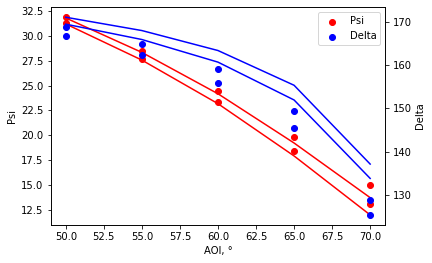

In [7]:
fig, ax = plt.subplots()
axt = ax.twinx()

for idx, wav in enumerate(np.unique(data.wavelength)):
    wavelength, aoi, d_psi, d_delta = list(data.unique_wavelength_data())[idx]
    
    psi, delta = model(np.c_[np.ones_like(aoi) * wavelength, aoi])
    ax.plot(aoi, psi, color='r')
    axt.plot(aoi, delta, color='b')

    p = ax.scatter(aoi, d_psi, color='r')
    d = axt.scatter(aoi, d_delta, color='b')

ax.legend(handles=[p,d], labels=['Psi', 'Delta'])
ax.set(ylabel='Psi', xlabel='AOI, °')
axt.set(ylabel='Delta')

In [8]:
objective = ObjectiveSE(model, data)

In [9]:
objective.residuals()

array([-0.07489973, -0.14926004, -0.29673199, -0.60701437, -1.30096573,
       -0.04674781, -0.10248017, -0.21820546, -0.47122099, -1.09163042,
        2.65638767,  3.51837138,  4.72878815,  6.46076346,  8.42972259,
        2.33378554,  3.1199899 ,  4.24923616,  5.98783724,  8.30932223])

In [10]:
fitter = CurveFitter(objective)
fitter.fit(method='least_squares');

### Model & data post fit

[Text(0, 0.5, 'Delta')]

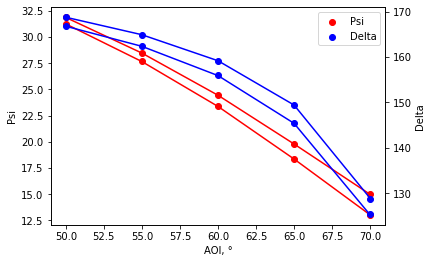

In [11]:
fig, ax = plt.subplots()
axt = ax.twinx()

for idx, wav in enumerate(np.unique(data.wavelength)):
    wavelength, aoi, d_psi, d_delta = list(data.unique_wavelength_data())[idx]
    
    psi, delta = model(np.c_[np.ones_like(aoi) * wavelength, aoi])
    ax.plot(aoi, psi, color='r')
    axt.plot(aoi, delta, color='b')

    p = ax.scatter(aoi, d_psi, color='r')
    d = axt.scatter(aoi, d_delta, color='b')

ax.legend(handles=[p,d], labels=['Psi', 'Delta'])
ax.set(ylabel='Psi', xlabel='AOI, °')
axt.set(ylabel='Delta')

In [12]:
for i, x in enumerate(objective.model.parameters):
    print(x)

________________________________________________________________________________
Parameters: 'instrument parameters'
<Parameter:'delta offset' , value=0 (fixed)  , bounds=[-inf, inf]>
________________________________________________________________________________
Parameters: 'Structure - ' 
________________________________________________________________________________
Parameters:       ''       
<Parameter:  ' - thick'   , value=0 (fixed)  , bounds=[-inf, inf]>
<Parameter:  ' - rough'   , value=0 (fixed)  , bounds=[-inf, inf]>
<Parameter:' - volfrac solvent', value=0 (fixed)  , bounds=[0.0, 1.0]>
________________________________________________________________________________
Parameters:       ''       
<Parameter:  ' - thick'   , value=194.232 +/- 0.143, bounds=[100.0, 500.0]>
<Parameter:  ' - rough'   , value=0 (fixed)  , bounds=[-inf, inf]>
<Parameter:' - volfrac solvent', value=0 (fixed)  , bounds=[0.0, 1.0]>
______________________________________________________________________

## Using the plotting tools

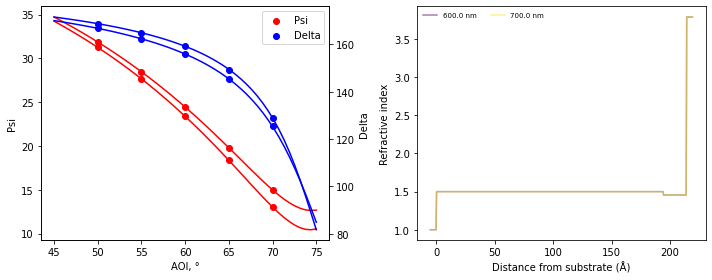

In [13]:
fig, ax = plt.subplots(1, 2, figsize=(10,4))

plot_ellipsdata(ax[0], data=data, model=model, xaxis='aoi')
plot_structure(ax[1], objective=objective)

fig.tight_layout()